# 1.0 Notebook Setup

Note: need to mount your Google Drive to use the adult dataset. 

In [2]:
# Optional - used by our team to record outputs
!pip install wandb

# Used for fairness evaluation metrics 
!pip install fairlearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 kB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 2.0 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8807 sha256=46189c7da59160891e962d8e3c9e51dc264152e40ff14a4dc7dccf355d13347e
  Stored in directory: /root/.cache/pip/wheels/b7/0a/67/ada2a22079218c75a88361c0782855cc72aebc4d18d0289d05
Successfully built pathtools
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.0/235.0 kB 9.2 MB/s eta 0:00:00


In [3]:
# Other imports 

import pandas as pd
import plotly
import plotly.express as px
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import linear_model, metrics, preprocessing
from datetime import datetime, timedelta

import wandb
import random

from fairlearn.postprocessing import ThresholdOptimizer, plot_threshold_optimizer
from fairlearn.metrics import demographic_parity_ratio, equalized_odds_ratio, demographic_parity_difference, equalized_odds_difference
from fairlearn.reductions import DemographicParity


from google.colab import drive

from sklearn.model_selection import KFold, cross_val_score


drive.mount('/content/drive')

Mounted at /content/drive


# 2.0 Supporting Functions and Classes

## 2.1 Defining Regularizers 

In [4]:
import torch
from torch import nn
from torch.nn import functional as F


class ConstraintLoss(nn.Module):
    def __init__(self, n_class=2, alpha=1, p_norm=2):
        super(ConstraintLoss, self).__init__()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.alpha = alpha
        self.p_norm = p_norm
        self.n_class = n_class
        self.n_constraints = 2
        self.dim_condition = self.n_class + 1
        self.M = torch.zeros((self.n_constraints, self.dim_condition))

    #NOTE!!! --> We never call the parent mu_f in super so it was removed

    def forward(self, X, out, sensitive, y=None):
        # Reshapes sensitive attribute tensor to the same shape as the output 
        sensitive = sensitive.view(out.shape)
        # Reshapes y (label) tensor to the same shape as the output 
        if isinstance(y, torch.Tensor):
            y = y.view(out.shape)

        #Take the sigmoid of 'out' which is the output of our model (aka the weights). 
        out = torch.sigmoid(out)

        # Get the mu_f value given these tensors by calling the subclass mu_f
        #mu_f is the expected value of a sensitive feature in DP
        # print("super forward -> sub-class mu_f called")
        mu = self.mu_f(X=X, out=out, sensitive=sensitive, y=y)
        
        # Gap constraint refers to the difference beteween the two sensitive classes as calculated by taking the .mv (dot product)
        # Apply relu to matrix vector product of M and mu which 
        # Using cuda if applicable (self.device references)
        gap_constraint = F.relu(
            torch.mv(self.M.to(self.device), mu.to(self.device))
        )
        # print("super forwad -> M*mu gap constraints")

        # Using the L2 Norm of the gap constraint as regularizer with alpha parameter. 
        if self.p_norm == 2:
            cons = self.alpha * torch.dot(gap_constraint, gap_constraint)
        else:
            cons = self.alpha * torch.dot(gap_constraint.detach(), gap_constraint)
        return cons


class DemographicParityLoss(ConstraintLoss):
    def __init__(self, sensitive_classes=[0, 1], alpha=1, p_norm=2):
        """loss of demograpfhic parity

        Args:
            sensitive_classes (list, optional): list of unique values of sensitive attribute. Defaults to [0, 1].
            alpha (int, optional): [description]. Defaults to 1.
            p_norm (int, optional): [description]. Defaults to 2.
        """
        self.sensitive_classes = sensitive_classes
        self.n_class = len(sensitive_classes)
        super(DemographicParityLoss, self).__init__(
            n_class=self.n_class, alpha=alpha, p_norm=p_norm
        )
        self.n_constraints = self.n_class
        self.dim_condition = self.n_class
        self.M = torch.zeros((self.n_constraints, self.dim_condition))
        for i in range(self.n_constraints):
            j = i % 2
            if j == 0:
                self.M[i, j] = 1.0
                self.M[i, 1] = -1.0
            else:
                self.M[i, j - 1] = -1.0
                self.M[i, 1] = 1.0
        # print("DP_init -> M defined")

    def mu_f(self, X, out, sensitive, y=None):
        # print("sub-class mu_f -> return exp vals")
        expected_values_list = []
        for v in self.sensitive_classes:
            # Get the index for each of the senstive classes 
            idx_true = sensitive == v  # torch.bool
            # Get the average prediction for that sensitive class
            expected_values_list.append(out[idx_true].mean())

        #expected_values_list will have two values, one for each sensitive class representing it's average prediction
        #if you look at forward you'll see we take the dot product of these two values with M
        return torch.stack(expected_values_list)

    def forward(self, X, out, sensitive, y=None):
        #Calls parent class forward function
        # print("sub-class forward -> call super forward")
        return super(DemographicParityLoss, self).forward(X, out, sensitive)


class EqualizedOddsLoss(ConstraintLoss):
    def __init__(self, sensitive_classes=[0, 1], alpha=1, p_norm=2):
        """loss of demograpfhic parity
        Args:
            sensitive_classes (list, optional): list of unique values of sensitive attribute. Defaults to [0, 1].
            alpha (int, optional): [description]. Defaults to 1.
            p_norm (int, optional): [description]. Defaults to 2.

            equalized odds: pr(y_hat | A=a, Y=y) = pr(y_hat | Y=y) for all a in A, y in Y.
            pr(y_hat =1 | A=a1, Y=y) = pr(y_hat =1 | A=a2, Y=y) for all y
        """
        self.sensitive_classes = sensitive_classes
        self.y_classes = [0, 1] # binary classification
        self.n_class = len(sensitive_classes)
        self.n_y_class = len(self.y_classes)
        super(EqualizedOddsLoss, self).__init__(n_class=self.n_class, alpha=alpha, p_norm=p_norm)
        # K:  number of constraint : (|A| x |Y| x {+, -})
        self.n_constraints = self.n_class * self.n_y_class
        # J : dim of conditions  : ((|A|+1) x |Y|)
        self.dim_condition = self.n_class* self.n_y_class
        self.M = torch.zeros((self.n_constraints, self.dim_condition))
        # print(self.M)
        #hard coded M matrix
        for i in range(self.n_constraints):
              if i==0:
                self.M[i, i] = 1.0
                self.M[i, i+2] = -1.0
              elif i == 1:
                self.M[i, i-1] = -1.0
                self.M[i, i+1] = 1.0
              elif i==2:
                self.M[i, i-1] = -1.0
                self.M[i, i+1] = 1.0
              elif i==3:
                self.M[i, i-2] = 1.0
                self.M[i, i] = -1.0
        #print(self.M)
                
    def mu_f(self, X, out, sensitive, y):
        expected_values_list = []
        # print(self.sensitive_classes)
        # print(self.y_classes)
        for u in self.sensitive_classes:
            for v in self.y_classes:
                # print("HERE")
                idx_true = (y == v) * (sensitive == u)  # torch.bool
                expected_values_list.append(out[idx_true].mean())
        # print(expected_values_list)
        # print("Loop")
        return torch.stack(expected_values_list)

    def forward(self, X, out, sensitive, y):
        return super(EqualizedOddsLoss, self).forward(X, out, sensitive, y=y)

## 2.2 Defining Models

In [5]:
def weights_init(m):
    if isinstance(m, nn.Linear):
        print ("HELLO")
        nn.init.xavier_uniform_(m.weight.data)
        # nn.init.xavier_uniform_(m.bias.data)
    
# https://towardsdatascience.com/logistic-regression-with-pytorch-3c8bbea594be
class LogisticRegression(torch.nn.Module):
     def __init__(self, input_dim, output_dim):
         super(LogisticRegression, self).__init__()
         self.linear = torch.nn.Linear(input_dim, output_dim)
     def forward(self, x):
         (self.linear) 

         outputs = torch.sigmoid(self.linear(x))
         return outputs


# https://medium.com/analytics-vidhya/pytorch-for-deep-learning-binary-classification-logistic-regression-382abd97fb43
class Net(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Net,self).__init__()
        self.fc1 = nn.Linear(input_dim, 32)
        self.fc2 = nn.Linear(32,16)
        self.fc3 = nn.Linear(16, output_dim)
    def forward(self,x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

## 2.3 Data Loaders

### 2.3.1 COMPAS

In [6]:
def load_compas(target_name = 'two_year_recid', sensitive_name = 'race'): 
  # Load Data 
  compas_link ='https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv'
  compas_data = pd.read_csv(compas_link, on_bad_lines='skip')

  # Trim Undesired Columns 
  compas_data = compas_data[['age' , 'juv_fel_count', 'juv_misd_count', 'juv_other_count', 'priors_count','sex','c_charge_degree','race','two_year_recid']]
  compas_to_oh = ['sex','c_charge_degree']

  # Fix Race 
  compas_data.loc[compas_data.race != 'Caucasian', 'race'] = 1
  compas_data.loc[compas_data.race == 'Caucasian', 'race'] = 0
  compas_data.race = compas_data.race.astype(int)

  # Get Target and Sensitive 
  target = compas_data[target_name]
  sensitive = compas_data[[sensitive_name]]

  # Remove target 
  #compas_data = compas_data[['age' , 'juv_fel_count', 'decile_score', 'juv_misd_count', 'juv_other_count', 'priors_count','sex','c_charge_degree','race']]
  
  # One-hot-encode sex & c_charge_degree
  compas_data = pd.get_dummies(compas_data, columns = compas_to_oh)
  #print (compas_data)

  # Returns x, y, sensitive (with sensitive still included in x )
  return compas_data, sensitive

  # # Load Data 
  # compas_link ='https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv'
  # compas_data = pd.read_csv(compas_link, on_bad_lines='skip')

  # # Trim Undesired Columns 
  # compas_data = compas_data[['age' , 'juv_fel_count', 'decile_score', 'juv_misd_count', 'juv_other_count', 'priors_count','sex','c_charge_degree','race','two_year_recid']]
  # compas_to_oh = ['sex','c_charge_degree']

  # # Fix Race 
  # compas_data.loc[compas_data.race != 'Caucasian', 'race'] = 1
  # compas_data.loc[compas_data.race == 'Caucasian', 'race'] = 0

  # # # Fix Race 
  # # compas_data.loc[compas_data.race != 'Caucasian', 'two_year_recid'] = 1
  # # compas_data.loc[compas_data.race == 'Caucasian', 'two_year_recid'] = 0

  # # Get Target and Sensitive 
  # target = compas_data[target_name]
  # sensitive = compas_data[[sensitive_name]]

  # # Remove target and one-hot-encode sex & c_charge_degree
  # # compas_data = compas_data[['age' , 'juv_fel_count', 'decile_score', 'juv_misd_count', 'juv_other_count', 'priors_count','sex','c_charge_degree','race']]
  # compas_data = pd.get_dummies(compas_data, columns = compas_to_oh)

  # # Returns x, y, sensitive (with sensitive still included in x )
  # return compas_data, sensitive_name

### 2.3.2 Adult

In [7]:
def load_adult(target_name = 'income', sensitive_name = 'sex_binary'): 

  # Load Data 
  adult_data = pd.read_csv("/content/drive/MyDrive/Project/Data/adult.csv")

  # Create binary for race 
  adult_data.loc[adult_data.race != ' White', 'race_binary'] = 1
  adult_data.loc[adult_data.race == ' White', 'race_binary'] = 0
  adult_data.race = adult_data.race_binary.astype(int)

  # Create binary for sex 
  adult_data.loc[adult_data.sex != ' Male', 'sex_binary'] = 1
  adult_data.loc[adult_data.sex == ' Male', 'sex_binary'] = 0
  adult_data.sex = adult_data.sex_binary.astype(int)

  # Create binary for income 
  adult_data.loc[adult_data.income != ' >50K', 'income'] = 0
  adult_data.loc[adult_data.income == ' >50K', 'income'] = 1
  adult_data.income = adult_data.income.astype(int)

  adult_data = adult_data[['marital-status','occupation','race_binary','sex_binary','education_num', 'capital_gain', 'capital_loss', 'hours_per_week','income']]

  # One hot encode 
  adult_to_oh = ['marital-status', 'occupation']
  adult_data = pd.get_dummies(adult_data,columns=adult_to_oh)
  
  sensitive = adult_data[sensitive_name]
  
  return adult_data, sensitive

def get_balanced_adult():
  # Load Data 
  df = pd.read_csv("/content/drive/MyDrive/Project/Data/adult.csv")

  df_pos = df.loc[df.income==' >50K']
  df_neg = df.loc[df.income==' <=50K']
  df_neg_sample = df_neg.sample(len(df_pos),random_state=15)
  df_new = pd.concat([df_pos,df_neg_sample],axis=0)
  return df_new

def load_adult_balanced(target_name = 'income', sensitive_name = 'sex_binary'):

  # Load Data 
  adult_data = get_balanced_adult()

  # Create binary for race 
  adult_data.loc[adult_data.race != ' White', 'race_binary'] = 1
  adult_data.loc[adult_data.race == ' White', 'race_binary'] = 0
  adult_data.race = adult_data.race_binary.astype(int)

  # Create binary for sex 
  adult_data.loc[adult_data.sex != ' Male', 'sex_binary'] = 1
  adult_data.loc[adult_data.sex == ' Male', 'sex_binary'] = 0
  adult_data.sex = adult_data.sex_binary.astype(int)

  # Create binary for income 
  adult_data.loc[adult_data.income != ' >50K', 'income'] = 0
  adult_data.loc[adult_data.income == ' >50K', 'income'] = 1
  adult_data.income = adult_data.income.astype(int)

  adult_data = adult_data[['marital-status','occupation','race_binary','sex_binary','education_num', 'capital_gain', 'capital_loss', 'hours_per_week','income']]

  # One hot encode 
  adult_to_oh = ['marital-status', 'occupation']
  adult_data = pd.get_dummies(adult_data,columns=adult_to_oh)
  
  sensitive = adult_data[sensitive_name]
  
  return adult_data, sensitive



### 2.3.3 Dutch

In [8]:
def label_encode(df,columns_to_encode):

  for i in columns_to_encode:
    tmp = df[i].iloc[0]
    
    if type(tmp) != int or type(tmp) != float:
      le = preprocessing.LabelEncoder()
      df[i] = le.fit_transform(df[i].values)

  return df

def load_dutch(target_name = 'occupation', sensitive_name = 'sex_binary'):

  # Load Data 
  dutch_link = 'https://github.com/tailequy/fairness_dataset/raw/main/experiments/data/dutch.csv'
  dutch_data = pd.read_csv(dutch_link, on_bad_lines='skip')

  # Create binary for sex 
  dutch_data.loc[dutch_data.sex != 'female', 'sex_binary'] = 0
  dutch_data.loc[dutch_data.sex == 'female', 'sex_binary'] = 1
  dutch_data.sex_binary = dutch_data.sex_binary.astype(int)

  # Label encode 
  dutch_to_keep = ['age','edu_level']
  dutch_to_encode = ['household_position','household_size','prev_residence_place','citizenship','country_birth','economic_status','cur_eco_activity','marital_status']

  dutch_data_le = dutch_data.copy()
  dutch_data_le = label_encode(dutch_data_le,dutch_to_encode)

  sensitive = dutch_data_le[sensitive_name]

  dutch_data_le = dutch_data_le[['age', 'household_position', 'household_size',
       'prev_residence_place', 'citizenship', 'country_birth', 'edu_level',
       'economic_status', 'cur_eco_activity', 'marital_status', 'occupation',
       'sex_binary']]
  
  return dutch_data_le, sensitive

## 2.4 Data Helpers

In [9]:
# def label_encode(df):

#   for i in df.columns:
#     tmp = df[i].iloc[0]
    
#     if type(tmp) != int or type(tmp) != float:
#       le = preprocessing.LabelEncoder()
#       df[i] = le.fit_transform(df[i].values)

#   return df

def one_hot(df):
  
  for i in df.columns:
    tmp = df[i].iloc[0]

    if i == 'Loan_Status':
      pass
    elif type(tmp) == str:
      df = pd.get_dummies(df, columns = [i])
      # ohe = preprocessing.OneHotEncoder()
      # df[i] =  ohe.fit_transform(df[i].values.reshape(-1, 1)) # double check the shape

  return df


def get_dataset(name, target = None, sensitive = None):
  if name == 'compas':
    print ("*")
    df, sensitive_name = load_compas()
  
  if name == 'adult':
    df, sensitive_name = load_adult()
  
  if name == 'adult_balanced':
    df, sensitive_name = load_adult_balanced()

  if name == 'dutch':
    df, sensitive_name = load_dutch()

  # else: 
  #   df = pd.read_csv("/content/drive/MyDrive/Project/Data/adult.csv")
  #   df = label_encode(df)

  return df, sensitive_name

def split(x, y, sensitive_features,  train_ratio, test_ratio):
  validation_ratio = 100 - train_ratio - test_ratio

  if validation_ratio < 0:
    print ("Incorrect Ratios")
    return -1

  # train is now 75% of the entire data set
  x_train, x_test, y_train, y_test, a_train, a_test = train_test_split(x, y, sensitive_features, test_size=1 - train_ratio, random_state=32)

  # test is now 10% of the initial data set
  # validation is now 15% of the initial data set
  x_val, x_test, y_val, y_test, a_val, a_test = train_test_split(x_test, y_test, a_test, test_size=test_ratio, random_state=32) 

  return  x_train, x_test, x_val, y_train, y_test, y_val, a_train, a_test, a_val


## 2.5 Evaluation Functions

In [10]:
def mae(prediction, true):
  return metrics.mean_absolute_error(prediction, true)

def accuracy(prediction, true):
  true = true.detach().numpy()
  prediction = prediction.detach().numpy()
  prediction = np.where( prediction <= 0.5, 0, 1)

  return (metrics.accuracy_score(prediction, true))

def precision(prediction, true):
  true = true.detach().numpy()
  prediction = prediction.detach().numpy()
  prediction = np.where( prediction <= 0.5, 0, 1)
  return (metrics.precision_score(prediction, true))

def recall(prediction, true):
  true = true.detach().numpy()
  prediction = prediction.detach().numpy()
  prediction = np.where( prediction <= 0.5, 0, 1)
  return (metrics.recall_score(prediction, true))

def tpr(prediction, true):
  return np.logical_and(prediction == 1, true== 1).sum()/prediction.shape[0]

def fpr(prediction, true):
  return np.logical_and(prediction == 1, true== 0).sum()/prediction.shape[0]

def tnr(prediction, true):
  return np.logical_and(prediction == 0, true== 0).sum()/prediction.shape[0]

def fnr(prediction, true):
  return np.logical_and(prediction == 0, true== 1).sum()/prediction.shape[0]

def dpr(prediction, true, sensitive_features):
  true = true.detach().numpy()
  sensitive_features = sensitive_features.detach().numpy()
  prediction = prediction.detach().numpy()
  prediction = np.where( prediction <= 0.5, 0, 1)
  return demographic_parity_ratio(true,prediction, sensitive_features=sensitive_features)

def dpd(prediction, true, sensitive_features):
  true = true.detach().numpy()
  sensitive_features = sensitive_features.detach().numpy()
  prediction = prediction.detach().numpy()
  prediction = np.where( prediction <= 0.5, 0, 1)
  return demographic_parity_difference(true,prediction, sensitive_features=sensitive_features)

def eor(prediction, true, sensitive_features):
  true = true.detach().numpy()
  sensitive_features = sensitive_features.detach().numpy()
  prediction = prediction.detach().numpy()
  prediction = np.where( prediction <= 0.5, 0, 1)
  return equalized_odds_ratio(true, prediction, sensitive_features=sensitive_features)

def eod(prediction, true, sensitive_features):
  true = true.detach().numpy()
  sensitive_features = sensitive_features.detach().numpy()
  prediction = prediction.detach().numpy()
  prediction = np.where( prediction <= 0.5, 0, 1)
  return equalized_odds_difference(true,prediction, sensitive_features=sensitive_features)
  

## 2.6 Train and Test Functions

In [11]:
def test(model, x_test, y_test, a_test):
  x_test, y_test, a_test = torch.tensor(x_test), torch.tensor(y_test), torch.tensor(a_test)
  outputs = model(x_test.float()) 
  loss = criterion(outputs, y_test.float())

  # log model results
  wandb.log({"test_loss": loss.item(), 
          "test_accuracy": accuracy(outputs, y_test), 
          "test_precision": precision(outputs, y_test), 
          "test_recall": recall(outputs, y_test),
          "test_dpr": dpr(outputs, y_test.float(),a_test ),
          "test_dpd": dpd(outputs, y_test.float(),a_test ),
          "test_eoo": eor(outputs, y_test.float(),a_test ),
          "test_edd": eod(outputs, y_test.float(),a_test )})
  wandb.watch(model)
  print ('Test Results, Loss: {:.4f},  Accuracy: {:.4f},  Precision: {:.4f},  Recall: {:.4f}' 
                  .format(loss.item(), 100 * accuracy(outputs, y_test),precision(outputs, y_test), recall(outputs, y_test)))

  return outputs, y_test

def train( model, criterion, optimizer, name,   lr,   x_train, x_val, y_train, y_val, a_train, a_val,sensitive,  alpha = None, regularizers = None, num_epochs = None):
  x_train, x_val, y_train, y_val, a_train, a_val = torch.from_numpy(x_train), torch.from_numpy(x_val), torch.from_numpy(y_train), torch.from_numpy(y_val), torch.from_numpy(a_train), torch.from_numpy(a_val)

  config= {
      "learning_rate":lr,
      "epochs": num_epochs,
      "model":model.__class__.__name__,
      "criterion":criterion.__class__.__name__,
      "optimizer":optimizer.__class__.__name__,
      "train_ratio":train_ratio, 
      "test_ratio":test_ratio,
      "data":name,
      "sensitive_race":sensitive
    }
  
  if regularizers != None:
    for i in range(len(regularizers)):
      config['regularizer_'+str(i)] = regularizers[i]
      config['alpha_'+str(i)] = alpha[i]

  # # store the hyperparameters in weights and bias
  wandb.init(project=name, entity="mie424",config = config)

  epoch_loss_train = []
  epoch_accuracy_train = []
  epoch_precision_train = []
  epoch_recall_train = []
  epoch_recall_dpr = []
  epoch_recall_dpd = []
  epoch_recall_eoo = []
  epoch_recall_eod = []
  
  epoch_loss_val = []
  epoch_accuracy_val = []
  epoch_precision_val = []
  epoch_recall_val = []
  epoch_dpr_val = []
  epoch_dpd_val = []
  epoch_eoo_val = []
  epoch_eod_val = []

  # train loop
  for epoch in range(num_epochs):

    outputs = []
    # for i in range(0, x_train.shape[0], 10):
    optimizer.zero_grad()
  
    # x_i = x_train[i].float()

    # Forward pass
    outputs   = model(x_train.float())  
        
    # outside of lop
    loss = criterion(outputs, y_train.float())
    if regularizers != None:
      # loss function
      for i in range(len(regularizers)):
        loss += regularizers[i](x_train.float(), outputs, a_train.float(), y_train.float()) #*alpha[i]
    # Backward and optimize
    
    loss.backward()
    optimizer.step()

    
    # store the epoch
    epoch_loss_train += [loss.item()]
    epoch_accuracy_train += [accuracy(outputs, y_train)]
    epoch_precision_train += [precision(outputs, y_train)]
    epoch_recall_train += [recall(outputs, y_train)]
    epoch_recall_dpr += [dpr(outputs, y_train.float(),a_train )]
    epoch_recall_dpd += [dpd(outputs, y_train.float(),a_train )]
    epoch_recall_eoo += [eor(outputs, y_train.float(),a_train )]
    epoch_recall_eod += [eod(outputs, y_train.float(),a_train )]

    # log model results
    wandb.log({"train_loss": epoch_loss_train[-1], 
              "train_accuracy": epoch_accuracy_train[-1], 
              "train_precision": epoch_precision_train[-1], 
              "train_recall": epoch_recall_train[-1],
              "train_dpr": epoch_recall_dpr[-1],
              "train_dpd": epoch_recall_dpd[-1],
              "train_eoo": epoch_recall_eoo[-1],
              "train_edd": epoch_recall_eod[-1]})
    
    wandb.watch(model)

    # print results
    print ('Epoch [{}/{}], Loss: {:.4f},  Accuracy: {:.4f},  Precision: {:.4f},  Recall: {:.4f}' 
                  .format(epoch+1, num_epochs, epoch_loss_train[-1], 100 * epoch_accuracy_train[-1],epoch_precision_train[-1],epoch_recall_train[-1]))
    
    # Validation loop
    with torch.no_grad():
      
      # model results
      outputs_v =  model(x_val.float()) 

      loss_v = criterion(outputs_v, y_val.float())
      if regularizers != None:
        # loss function
        for i in range(len(regularizers)):
          loss_v += regularizers[i](x_val.float(), outputs_v, a_val.float(), y_val.float()) #* alpha[i]
      

    
      # store resulst for the pass through
      epoch_loss_val += [loss_v.item()]
      #print(epoch_loss_val)
      epoch_accuracy_val += [accuracy(outputs_v, y_val)]
      epoch_precision_val += [precision(outputs_v, y_val)]
      epoch_recall_val += [recall(outputs_v, y_val)]
      epoch_dpr_val += [dpr(outputs_v, y_val.float(),a_val)]
      epoch_dpd_val += [dpd(outputs_v, y_val.float(),a_val)]
      epoch_eoo_val += [eor(outputs_v, y_val.float(),a_val)]
      epoch_eod_val += [eod(outputs_v, y_val.float(),a_val)]
        
      # log and print model results
      wandb.log({"val_loss": epoch_loss_val[-1], 
                  "val_accuracy": epoch_accuracy_val[-1], 
                  "val_precision": epoch_precision_val[-1], 
                  "val_recall": epoch_recall_val[-1],
                  "val_dpr": epoch_recall_dpr[-1],
                  "val_dpd": epoch_recall_dpd[-1],
                  "val_eoo": epoch_recall_eoo[-1],
                  "val_edd": epoch_recall_eod[-1] })
      wandb.watch(model)

      print('Accuracy of validation : {} % ,  Loss: {:.4f},  Precision: {:.4f},  Recall: {:.4f}'.format(100 * epoch_accuracy_val[-1], epoch_loss_val[-1],epoch_precision_val[-1], epoch_recall_val[-1])) 

  return outputs, y_train, outputs_v, y_val
  # print ()

# 3.0 Experimentation Loop

In [12]:
# wandb.login()
# get df
name = "dutch"

df, sensitive_name = get_dataset(name)

if name == "compas":
   x_var, y_var, sensitive = ['age', 'juv_fel_count', 'juv_misd_count', 'juv_other_count',
       'priors_count', 'race', 'sex_Female', 'sex_Male',
       'c_charge_degree_F', 'c_charge_degree_M'], ['two_year_recid'], ['race']
elif name == "dutch":
   x_var, y_var, sensitive = ['age', 'household_position', 'household_size',
       'prev_residence_place', 'citizenship', 'country_birth', 'edu_level',
       'economic_status', 'cur_eco_activity', 'marital_status',
       'sex_binary'], ['occupation'], ['sex_binary']
else:
  x_var, y_var, sensitive = ['race_binary', 'education_num', 'capital_gain',
       'capital_loss', 'hours_per_week',  'marital-status_ Divorced',
      #  'marital-status_ Married-AF-spouse',
       'marital-status_ Married-civ-spouse',
      #  'marital-status_ Married-spouse-absent',
      'marital-status_ Never-married','occupation_ Exec-managerial',  'occupation_ Prof-specialty',
      # 'marital-status_ Separated',
      #  'marital-status_ Widowed', 
      #  'occupation_ ?', 'occupation_ Adm-clerical',
      #  'occupation_ Armed-Forces', 'occupation_ Craft-repair',
      #  'occupation_ Farming-fishing',
      #  'occupation_ Handlers-cleaners', 'occupation_ Machine-op-inspct',
      #  'occupation_ Other-service', 'occupation_ Priv-house-serv',
      #  'occupation_ Protective-serv',
      #  'occupation_ Sales', 'occupation_ Tech-support'
       ], ['income'], ['sex_binary']
  # 'Loan_Amount_Term','LoanAmount',

name = "dutch_logistic_regression_v2"

train_ratio, test_ratio = 0.7, 0.66

# select x, y, and sensitive features
x = df[x_var].values.astype(float)
y = df[y_var].values
sensitive_features = df[sensitive].values.astype(float)


# split 
x_train, x_test, x_val, y_train, y_test, y_val, a_train, a_test, a_val = split(x, y, sensitive_features, train_ratio, test_ratio)

print (x_train.shape[1])
Alpha_1, Alpha_2  = [0,1000,5000,10000,50000],[0,1000,5000,10000,50000] #[0,1,10,100,300,600,1000,3000, 6000, 12000], [0,1,10,100,300,600,1000,3000, 6000, 12000]
num_epochs = 200


for alpha_dp in Alpha_1:
  for alpha_eo in Alpha_2:
    print (alpha_dp, alpha_eo)

    DemographicParity = DemographicParityLoss(sensitive_classes=[0, 1], alpha=alpha_dp) # constraint 
    EqualizedOdds = EqualizedOddsLoss(sensitive_classes=[0, 1], alpha=alpha_eo) # constraint 


    alphas = [alpha_dp,alpha_eo]
    regularizers = [DemographicParity,EqualizedOdds]
    # regularizers = [EqualizedOdds]
    input_dim =  x_train.shape[1]# Two inputs x1 and x2 
    output_dim = 1 # Single binary output 
    #lr = 0.0015 # compas
    #lr = 0.0003 # adult 
    # lr = 0.00005 # adult balanced
    lr = 0.05
    #lr = 0.00009
    #torch.manual_seed(18)
    torch.manual_seed(11) # adult-balanced
    torch.manual_seed(15) # dutch
    torch.manual_seed(29) # dutch 2
    model = LogisticRegression(input_dim,output_dim)
    
    #model = Net(input_dim, output_dim) # NN

    criterion = torch.nn.BCELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)

    #outputs_train, y_train, outputs_val, y_val = 
    train( model, 
                                                        criterion=criterion, 
                                                        optimizer=optimizer, 
                                                        name=name, 
                                                        lr=lr, 
                                                        x_train=x_train, 
                                                        x_val=x_val, 
                                                        y_train=y_train, 
                                                        y_val=y_val, 
                                                        a_train=a_train, 
                                                        a_val=a_val,  
                                                        alpha = alphas,
                                                        sensitive =  sensitive_name,
                                                        regularizers = regularizers, 
                                                        num_epochs = num_epochs)

    outputs_test, y_test = test(model, x_test, y_test, a_test)
    # wandb.finish()


11
0 0


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: WARNING Serializing object of type Series that is 483504 bytes


Epoch [1/200], Loss: 0.9326,  Accuracy: 43.2341,  Precision: 0.6625,  Recall: 0.4370
Accuracy of validation : 43.68002596138245 % ,  Loss: 0.8794,  Precision: 0.4026,  Recall: 0.4008
Epoch [2/200], Loss: 0.8791,  Accuracy: 43.2152,  Precision: 0.3984,  Recall: 0.4032
Accuracy of validation : 43.16079831251014 % ,  Loss: 0.8573,  Precision: 0.5055,  Recall: 0.4139
Epoch [3/200], Loss: 0.8555,  Accuracy: 43.3074,  Precision: 0.5076,  Recall: 0.4214
Accuracy of validation : 42.94986208015577 % ,  Loss: 0.8383,  Precision: 0.4679,  Recall: 0.4066
Epoch [4/200], Loss: 0.8366,  Accuracy: 42.9977,  Precision: 0.4684,  Recall: 0.4135
Accuracy of validation : 42.771377575855915 % ,  Loss: 0.8223,  Precision: 0.4917,  Recall: 0.4090
Epoch [5/200], Loss: 0.8200,  Accuracy: 43.1584,  Precision: 0.5020,  Recall: 0.4195
Accuracy of validation : 42.59289307155606 % ,  Loss: 0.8078,  Precision: 0.4896,  Recall: 0.4074
Epoch [6/200], Loss: 0.8054,  Accuracy: 43.0851,  Precision: 0.5013,  Recall: 0.4189

test_accuracy,▁
test_dpd,▁
test_dpr,▁
test_edd,▁
test_eoo,▁
test_loss,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▁▂▂▃▄▅▅▆▆▇▇▇▇▇▇▇▇▇█████████████████████
train_dpd,▇▆▄▃▁▁▂▃▄▄▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇█████████
train_dpr,▂▃▅▆██▇▆▅▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁


wandb: WARNING Serializing object of type Series that is 483504 bytes


Epoch [1/200], Loss: 3.0069,  Accuracy: 43.2341,  Precision: 0.6625,  Recall: 0.4370
Accuracy of validation : 46.95765049488885 % ,  Loss: 1.8087,  Precision: 1.0000,  Recall: 0.4696
Epoch [2/200], Loss: 1.7911,  Accuracy: 47.6627,  Precision: 1.0000,  Recall: 0.4766
Accuracy of validation : 45.5784520525718 % ,  Loss: 0.9404,  Precision: 0.8690,  Recall: 0.4581
Epoch [3/200], Loss: 1.0066,  Accuracy: 47.2135,  Precision: 0.8821,  Recall: 0.4713
Accuracy of validation : 46.95765049488885 % ,  Loss: 1.1485,  Precision: 1.0000,  Recall: 0.4696
Epoch [4/200], Loss: 1.1322,  Accuracy: 47.6627,  Precision: 1.0000,  Recall: 0.4766
Accuracy of validation : 45.351289956190165 % ,  Loss: 0.7618,  Precision: 0.5494,  Recall: 0.4351
Epoch [5/200], Loss: 0.7773,  Accuracy: 46.2701,  Precision: 0.5594,  Recall: 0.4489
Accuracy of validation : 45.36751582021743 % ,  Loss: 0.8605,  Precision: 0.8082,  Recall: 0.4541
Epoch [6/200], Loss: 0.8282,  Accuracy: 46.9179,  Precision: 0.8241,  Recall: 0.4677


<ipython-input-11-d5d26765fac5>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test, y_test, a_test = torch.tensor(x_test), torch.tensor(y_test), torch.tensor(a_test)


Test Results, Loss: 0.6117,  Accuracy: 64.5018,  Precision: 0.8857,  Recall: 0.5846
0 5000


test_accuracy,▁
test_dpd,▁
test_dpr,▁
test_edd,▁
test_eoo,▁
test_loss,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▁▁▂▃▂▃▃▄▆▃▅▅▇▇█████████████████████████
train_dpd,▁▃▂▃▄▂▆▆▇▆▄▇███████▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
train_dpr,█▇▇▆▆█▂▂▁▅▇▂▁▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃


wandb: WARNING Serializing object of type Series that is 483504 bytes


Epoch [1/200], Loss: 11.3041,  Accuracy: 43.2341,  Precision: 0.6625,  Recall: 0.4370
Accuracy of validation : 46.95765049488885 % ,  Loss: 30.5065,  Precision: 1.0000,  Recall: 0.4696
Epoch [2/200], Loss: 30.1497,  Accuracy: 47.6627,  Precision: 1.0000,  Recall: 0.4766
Accuracy of validation : 46.95765049488885 % ,  Loss: 25.9983,  Precision: 1.0000,  Recall: 0.4696
Epoch [3/200], Loss: 25.9843,  Accuracy: 47.6627,  Precision: 1.0000,  Recall: 0.4766
Accuracy of validation : 46.95765049488885 % ,  Loss: 20.3998,  Precision: 1.0000,  Recall: 0.4696
Epoch [4/200], Loss: 20.3522,  Accuracy: 47.6627,  Precision: 1.0000,  Recall: 0.4766
Accuracy of validation : 46.97387635891611 % ,  Loss: 13.7050,  Precision: 1.0000,  Recall: 0.4697
Epoch [5/200], Loss: 13.8776,  Accuracy: 47.6722,  Precision: 1.0000,  Recall: 0.4767
Accuracy of validation : 47.34707123154308 % ,  Loss: 8.3803,  Precision: 1.0000,  Recall: 0.4714
Epoch [6/200], Loss: 8.3702,  Accuracy: 47.9346,  Precision: 1.0000,  Recall

<ipython-input-11-d5d26765fac5>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test, y_test, a_test = torch.tensor(x_test), torch.tensor(y_test), torch.tensor(a_test)


Test Results, Loss: 3.0822,  Accuracy: 47.7349,  Precision: 1.0000,  Recall: 0.4773
0 10000


test_accuracy,▁
test_dpd,▁
test_dpr,▁
test_edd,▁
test_eoo,▁
test_loss,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▄▁▄▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁
train_dpd,▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▆▁▅▁▁▁▁▂▁▁█▁▁▁▁▁▁▁▁▁
train_dpr,██▇████████████████▇▄█▅████▇██▁█████████


wandb: WARNING Serializing object of type Series that is 483504 bytes


Epoch [1/200], Loss: 21.6756,  Accuracy: 43.2341,  Precision: 0.6625,  Recall: 0.4370
Accuracy of validation : 46.95765049488885 % ,  Loss: 51.2313,  Precision: 1.0000,  Recall: 0.4696
Epoch [2/200], Loss: 50.6301,  Accuracy: 47.6627,  Precision: 1.0000,  Recall: 0.4766
Accuracy of validation : 46.95765049488885 % ,  Loss: 51.2025,  Precision: 1.0000,  Recall: 0.4696
Epoch [3/200], Loss: 50.5965,  Accuracy: 47.6627,  Precision: 1.0000,  Recall: 0.4766
Accuracy of validation : 46.95765049488885 % ,  Loss: 51.1186,  Precision: 1.0000,  Recall: 0.4696
Epoch [4/200], Loss: 50.5392,  Accuracy: 47.6627,  Precision: 1.0000,  Recall: 0.4766
Accuracy of validation : 46.95765049488885 % ,  Loss: 50.9928,  Precision: 1.0000,  Recall: 0.4696
Epoch [5/200], Loss: 50.4371,  Accuracy: 47.6627,  Precision: 1.0000,  Recall: 0.4766
Accuracy of validation : 46.95765049488885 % ,  Loss: 50.9636,  Precision: 1.0000,  Recall: 0.4696
Epoch [6/200], Loss: 50.3896,  Accuracy: 47.6627,  Precision: 1.0000,  Reca

<ipython-input-11-d5d26765fac5>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test, y_test, a_test = torch.tensor(x_test), torch.tensor(y_test), torch.tensor(a_test)


Test Results, Loss: 4.3771,  Accuracy: 47.7349,  Precision: 1.0000,  Recall: 0.4773
0 50000


test_accuracy,▁
test_dpd,▁
test_dpr,▁
test_edd,▁
test_eoo,▁
test_loss,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▁▁▁▁▁▁▁▂▄▇█████████▇▅▆▁▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_dpd,▁▁▁▁▁▁▁▁▂▄▇█████████▇▆▇▁▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_dpr,████████▇▅▂▁▁▁▁▁▁▁▁▁▂▃▂█▆███████████████


wandb: WARNING Serializing object of type Series that is 483504 bytes


Epoch [1/200], Loss: 104.6475,  Accuracy: 43.2341,  Precision: 0.6625,  Recall: 0.4370
Accuracy of validation : 46.95765049488885 % ,  Loss: 53.0424,  Precision: 1.0000,  Recall: 0.4696
Epoch [2/200], Loss: 52.3373,  Accuracy: 47.6627,  Precision: 1.0000,  Recall: 0.4766
Accuracy of validation : 46.95765049488885 % ,  Loss: 53.0424,  Precision: 1.0000,  Recall: 0.4696
Epoch [3/200], Loss: 52.3373,  Accuracy: 47.6627,  Precision: 1.0000,  Recall: 0.4766
Accuracy of validation : 46.95765049488885 % ,  Loss: 53.0424,  Precision: 1.0000,  Recall: 0.4696
Epoch [4/200], Loss: 52.3373,  Accuracy: 47.6627,  Precision: 1.0000,  Recall: 0.4766
Accuracy of validation : 46.95765049488885 % ,  Loss: 53.0424,  Precision: 1.0000,  Recall: 0.4696
Epoch [5/200], Loss: 52.3373,  Accuracy: 47.6627,  Precision: 1.0000,  Recall: 0.4766
Accuracy of validation : 46.95765049488885 % ,  Loss: 53.0424,  Precision: 1.0000,  Recall: 0.4696
Epoch [6/200], Loss: 52.3373,  Accuracy: 47.6627,  Precision: 1.0000,  Rec

<ipython-input-11-d5d26765fac5>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test, y_test, a_test = torch.tensor(x_test), torch.tensor(y_test), torch.tensor(a_test)


Test Results, Loss: 52.2651,  Accuracy: 47.7349,  Precision: 1.0000,  Recall: 0.4773
1000 0


test_accuracy,▁
test_dpd,▁
test_dpr,▁
test_edd,▁
test_eoo,▁
test_loss,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_dpd,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_dpr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


wandb: WARNING Serializing object of type Series that is 483504 bytes


Epoch [1/200], Loss: 1.9162,  Accuracy: 43.2341,  Precision: 0.6625,  Recall: 0.4370
Accuracy of validation : 46.95765049488885 % ,  Loss: 1.2993,  Precision: 1.0000,  Recall: 0.4696
Epoch [2/200], Loss: 1.2856,  Accuracy: 47.6627,  Precision: 1.0000,  Recall: 0.4766
Accuracy of validation : 44.65357780301801 % ,  Loss: 0.8999,  Precision: 0.6113,  Recall: 0.4363
Epoch [3/200], Loss: 0.8547,  Accuracy: 45.7617,  Precision: 0.6236,  Recall: 0.4502
Accuracy of validation : 46.97387635891611 % ,  Loss: 0.7474,  Precision: 0.5166,  Recall: 0.4444
Epoch [4/200], Loss: 0.7439,  Accuracy: 47.5587,  Precision: 0.5263,  Recall: 0.4565
Accuracy of validation : 46.99010222294337 % ,  Loss: 0.7479,  Precision: 0.6873,  Recall: 0.4571
Epoch [5/200], Loss: 0.7385,  Accuracy: 48.2444,  Precision: 0.6989,  Recall: 0.4711
Accuracy of validation : 47.687814376115526 % ,  Loss: 0.7394,  Precision: 0.5867,  Recall: 0.4557
Epoch [6/200], Loss: 0.7340,  Accuracy: 48.3650,  Precision: 0.5949,  Recall: 0.4673

<ipython-input-11-d5d26765fac5>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test, y_test, a_test = torch.tensor(x_test), torch.tensor(y_test), torch.tensor(a_test)


Test Results, Loss: 0.5967,  Accuracy: 68.7312,  Precision: 0.7167,  Recall: 0.6585
1000 1000


test_accuracy,▁
test_dpd,▁
test_dpr,▁
test_edd,▁
test_eoo,▁
test_loss,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▁▂▃▃▄▄▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇██████████████████
train_dpd,▁▃▄▄▂▃▄▄▆▇▆▆▆▇▇▇▆▆▆▅▆▆██▇▇██▇▇▇▇▇▇▇▇▇▇▇▇
train_dpr,█▆▆▅▇▆▆▆▄▃▃▃▃▂▂▂▃▃▃▄▃▃▁▁▁▂▁▁▂▂▂▂▂▂▂▂▂▂▂▂


wandb: WARNING Serializing object of type Series that is 483504 bytes


Epoch [1/200], Loss: 3.9905,  Accuracy: 43.2341,  Precision: 0.6625,  Recall: 0.4370
Accuracy of validation : 46.95765049488885 % ,  Loss: 2.9018,  Precision: 1.0000,  Recall: 0.4696
Epoch [2/200], Loss: 2.8728,  Accuracy: 47.6627,  Precision: 1.0000,  Recall: 0.4766
Accuracy of validation : 46.95765049488885 % ,  Loss: 1.5592,  Precision: 1.0000,  Recall: 0.4696
Epoch [3/200], Loss: 1.5472,  Accuracy: 47.6627,  Precision: 1.0000,  Recall: 0.4766
Accuracy of validation : 48.710043809832875 % ,  Loss: 1.7090,  Precision: 0.9741,  Recall: 0.4774
Epoch [4/200], Loss: 1.8669,  Accuracy: 49.5519,  Precision: 0.9777,  Recall: 0.4855
Accuracy of validation : 46.95765049488885 % ,  Loss: 3.7705,  Precision: 1.0000,  Recall: 0.4696
Epoch [5/200], Loss: 3.7367,  Accuracy: 47.6627,  Precision: 1.0000,  Recall: 0.4766
Accuracy of validation : 46.95765049488885 % ,  Loss: 2.2948,  Precision: 1.0000,  Recall: 0.4696
Epoch [6/200], Loss: 2.2734,  Accuracy: 47.6627,  Precision: 1.0000,  Recall: 0.4766

<ipython-input-11-d5d26765fac5>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test, y_test, a_test = torch.tensor(x_test), torch.tensor(y_test), torch.tensor(a_test)


Test Results, Loss: 1.0128,  Accuracy: 48.0859,  Precision: 0.9988,  Recall: 0.4790
1000 5000


test_accuracy,▁
test_dpd,▁
test_dpr,▁
test_edd,▁
test_eoo,▁
test_loss,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▁▁▁▁▂▁▂▁▄▆▁▁▆▁▁▇▆▁▆▄▆▁▅▇▆▃▅▇▁▇▅▇▇▃▇█▁▇▅
train_dpd,▁▁▁▃▁█▁▃▁▅▅▁▁▃▁▂▃▃▁▁▂▃▁▁▆▂▂▂▄▁▇▁▅▅▃▂▆▁▇▆
train_dpr,███▇█▁█▇█▆▅██▇█▇▇▆██▇▇██▅▇▇▇▆█▄█▅▆▇▇▄█▅▅


wandb: WARNING Serializing object of type Series that is 483504 bytes


Epoch [1/200], Loss: 12.2876,  Accuracy: 43.2341,  Precision: 0.6625,  Recall: 0.4370
Accuracy of validation : 46.95765049488885 % ,  Loss: 35.9476,  Precision: 1.0000,  Recall: 0.4696
Epoch [2/200], Loss: 35.3402,  Accuracy: 47.6627,  Precision: 1.0000,  Recall: 0.4766
Accuracy of validation : 46.95765049488885 % ,  Loss: 33.7779,  Precision: 1.0000,  Recall: 0.4696
Epoch [3/200], Loss: 33.2474,  Accuracy: 47.6627,  Precision: 1.0000,  Recall: 0.4766
Accuracy of validation : 46.95765049488885 % ,  Loss: 31.0450,  Precision: 1.0000,  Recall: 0.4696
Epoch [4/200], Loss: 30.6039,  Accuracy: 47.6627,  Precision: 1.0000,  Recall: 0.4766
Accuracy of validation : 46.95765049488885 % ,  Loss: 27.2964,  Precision: 1.0000,  Recall: 0.4696
Epoch [5/200], Loss: 26.9248,  Accuracy: 47.6627,  Precision: 1.0000,  Recall: 0.4766
Accuracy of validation : 46.95765049488885 % ,  Loss: 21.8633,  Precision: 1.0000,  Recall: 0.4696
Epoch [6/200], Loss: 21.9352,  Accuracy: 47.6627,  Precision: 1.0000,  Reca

<ipython-input-11-d5d26765fac5>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test, y_test, a_test = torch.tensor(x_test), torch.tensor(y_test), torch.tensor(a_test)


Test Results, Loss: 2.1876,  Accuracy: 47.7767,  Precision: 0.9996,  Recall: 0.4775
1000 10000


test_accuracy,▁
test_dpd,▁
test_dpr,▁
test_edd,▁
test_eoo,▁
test_loss,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▁▁▁▁▁▁▁▁▄▂▁▁▁▁▁▁▁▄▁▁▁▁▁▁▄▁▁▁▁▃▁▃▁▁▁▁▁█▁
train_dpd,▁▁▁▁▁▁▁▁▁▄▁▁▂▂▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▄▁
train_dpr,█████████▇████████▁███████████████████▆█


wandb: WARNING Serializing object of type Series that is 483504 bytes


Epoch [1/200], Loss: 22.6591,  Accuracy: 43.2341,  Precision: 0.6625,  Recall: 0.4370
Accuracy of validation : 46.95765049488885 % ,  Loss: 51.8200,  Precision: 1.0000,  Recall: 0.4696
Epoch [2/200], Loss: 51.2443,  Accuracy: 47.6627,  Precision: 1.0000,  Recall: 0.4766
Accuracy of validation : 46.95765049488885 % ,  Loss: 51.7914,  Precision: 1.0000,  Recall: 0.4696
Epoch [3/200], Loss: 51.1898,  Accuracy: 47.6627,  Precision: 1.0000,  Recall: 0.4766
Accuracy of validation : 46.95765049488885 % ,  Loss: 51.7906,  Precision: 1.0000,  Recall: 0.4696
Epoch [4/200], Loss: 51.1811,  Accuracy: 47.6627,  Precision: 1.0000,  Recall: 0.4766
Accuracy of validation : 46.95765049488885 % ,  Loss: 51.7625,  Precision: 1.0000,  Recall: 0.4696
Epoch [5/200], Loss: 51.1585,  Accuracy: 47.6627,  Precision: 1.0000,  Recall: 0.4766
Accuracy of validation : 46.95765049488885 % ,  Loss: 51.7476,  Precision: 1.0000,  Recall: 0.4696
Epoch [6/200], Loss: 51.1379,  Accuracy: 47.6627,  Precision: 1.0000,  Reca

<ipython-input-11-d5d26765fac5>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test, y_test, a_test = torch.tensor(x_test), torch.tensor(y_test), torch.tensor(a_test)


Test Results, Loss: 2.7987,  Accuracy: 47.7349,  Precision: 1.0000,  Recall: 0.4773
1000 50000


test_accuracy,▁
test_dpd,▁
test_dpr,▁
test_edd,▁
test_eoo,▁
test_loss,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▄▇▇██████████▇▆▅▁▂▁▁▁▁▁▁▁▁▁▁
train_dpd,▁▁▁▁▁▁▁▁▁▁▁▁▃▆▇▇▇████████▇▆▆▁▂▁▁▁▁▁▁▁▁▁▁
train_dpr,████████████▆▃▂▂▂▁▁▁▁▁▁▁▁▂▃▃█▇██████████


wandb: WARNING Serializing object of type Series that is 483504 bytes


Epoch [1/200], Loss: 105.6310,  Accuracy: 43.2341,  Precision: 0.6625,  Recall: 0.4370
Accuracy of validation : 46.95765049488885 % ,  Loss: 53.0424,  Precision: 1.0000,  Recall: 0.4696
Epoch [2/200], Loss: 52.3373,  Accuracy: 47.6627,  Precision: 1.0000,  Recall: 0.4766
Accuracy of validation : 46.95765049488885 % ,  Loss: 53.0424,  Precision: 1.0000,  Recall: 0.4696
Epoch [3/200], Loss: 52.3373,  Accuracy: 47.6627,  Precision: 1.0000,  Recall: 0.4766
Accuracy of validation : 46.95765049488885 % ,  Loss: 53.0424,  Precision: 1.0000,  Recall: 0.4696
Epoch [4/200], Loss: 52.3373,  Accuracy: 47.6627,  Precision: 1.0000,  Recall: 0.4766
Accuracy of validation : 46.95765049488885 % ,  Loss: 53.0424,  Precision: 1.0000,  Recall: 0.4696
Epoch [5/200], Loss: 52.3373,  Accuracy: 47.6627,  Precision: 1.0000,  Recall: 0.4766
Accuracy of validation : 46.95765049488885 % ,  Loss: 53.0424,  Precision: 1.0000,  Recall: 0.4696
Epoch [6/200], Loss: 52.3373,  Accuracy: 47.6627,  Precision: 1.0000,  Rec

<ipython-input-11-d5d26765fac5>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test, y_test, a_test = torch.tensor(x_test), torch.tensor(y_test), torch.tensor(a_test)


Test Results, Loss: 52.2651,  Accuracy: 47.7349,  Precision: 1.0000,  Recall: 0.4773
5000 0


test_accuracy,▁
test_dpd,▁
test_dpr,▁
test_edd,▁
test_eoo,▁
test_loss,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_dpd,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_dpr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


wandb: WARNING Serializing object of type Series that is 483504 bytes


Epoch [1/200], Loss: 5.8502,  Accuracy: 43.2341,  Precision: 0.6625,  Recall: 0.4370
Accuracy of validation : 46.95765049488885 % ,  Loss: 5.6534,  Precision: 1.0000,  Recall: 0.4696
Epoch [2/200], Loss: 5.6145,  Accuracy: 47.6627,  Precision: 1.0000,  Recall: 0.4766
Accuracy of validation : 46.95765049488885 % ,  Loss: 4.1304,  Precision: 1.0000,  Recall: 0.4696
Epoch [3/200], Loss: 4.0862,  Accuracy: 47.6627,  Precision: 1.0000,  Recall: 0.4766
Accuracy of validation : 46.95765049488885 % ,  Loss: 2.6616,  Precision: 1.0000,  Recall: 0.4696
Epoch [4/200], Loss: 2.6292,  Accuracy: 47.6627,  Precision: 1.0000,  Recall: 0.4766
Accuracy of validation : 48.85607658607821 % ,  Loss: 3.2174,  Precision: 0.9965,  Recall: 0.4786
Epoch [5/200], Loss: 3.2956,  Accuracy: 49.4668,  Precision: 0.9972,  Recall: 0.4853
Accuracy of validation : 46.95765049488885 % ,  Loss: 28.7886,  Precision: 1.0000,  Recall: 0.4696
Epoch [6/200], Loss: 29.1916,  Accuracy: 47.6627,  Precision: 1.0000,  Recall: 0.476

<ipython-input-11-d5d26765fac5>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test, y_test, a_test = torch.tensor(x_test), torch.tensor(y_test), torch.tensor(a_test)


Test Results, Loss: 0.6670,  Accuracy: 66.4410,  Precision: 0.6957,  Recall: 0.6357
5000 1000


test_accuracy,▁
test_dpd,▁
test_dpr,▁
test_edd,▁
test_eoo,▁
test_loss,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▁▁▁▃▁▁▂▁▁█▁▇▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇█
train_dpd,▁▁▁▁▂▁▁▃▁▁█▂▃▁▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
train_dpr,████▇██▇██▁▇▅█▇▆▇▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇


wandb: WARNING Serializing object of type Series that is 483504 bytes


Epoch [1/200], Loss: 7.9245,  Accuracy: 43.2341,  Precision: 0.6625,  Recall: 0.4370
Accuracy of validation : 46.95765049488885 % ,  Loss: 17.9505,  Precision: 1.0000,  Recall: 0.4696
Epoch [2/200], Loss: 18.2156,  Accuracy: 47.6627,  Precision: 1.0000,  Recall: 0.4766
Accuracy of validation : 46.95765049488885 % ,  Loss: 8.5678,  Precision: 1.0000,  Recall: 0.4696
Epoch [3/200], Loss: 8.7004,  Accuracy: 47.6627,  Precision: 1.0000,  Recall: 0.4766
Accuracy of validation : 46.95765049488885 % ,  Loss: 5.0505,  Precision: 1.0000,  Recall: 0.4696
Epoch [4/200], Loss: 4.9600,  Accuracy: 47.6627,  Precision: 1.0000,  Recall: 0.4766
Accuracy of validation : 46.99010222294337 % ,  Loss: 3.5048,  Precision: 1.0000,  Recall: 0.4697
Epoch [5/200], Loss: 3.4611,  Accuracy: 47.7006,  Precision: 1.0000,  Recall: 0.4768
Accuracy of validation : 49.050786954405325 % ,  Loss: 3.5612,  Precision: 0.9965,  Recall: 0.4795
Epoch [6/200], Loss: 3.5186,  Accuracy: 49.5543,  Precision: 0.9965,  Recall: 0.48

<ipython-input-11-d5d26765fac5>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test, y_test, a_test = torch.tensor(x_test), torch.tensor(y_test), torch.tensor(a_test)


Test Results, Loss: 48.7161,  Accuracy: 47.7349,  Precision: 1.0000,  Recall: 0.4773
5000 5000


test_accuracy,▁
test_dpd,▁
test_dpr,▁
test_edd,▁
test_eoo,▁
test_loss,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▆▁▁▁▁▂█▁▁▁▁▁▁▁▁▁▁
train_dpd,▁▃▂▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▃▂▅▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁
train_dpr,█▇▇████▇█████████████▆▇▄█████▁██████████


wandb: WARNING Serializing object of type Series that is 483504 bytes


Epoch [1/200], Loss: 16.2217,  Accuracy: 43.2341,  Precision: 0.6625,  Recall: 0.4370
Accuracy of validation : 46.95765049488885 % ,  Loss: 48.9464,  Precision: 1.0000,  Recall: 0.4696
Epoch [2/200], Loss: 48.3895,  Accuracy: 47.6627,  Precision: 1.0000,  Recall: 0.4766
Accuracy of validation : 46.95765049488885 % ,  Loss: 48.7494,  Precision: 1.0000,  Recall: 0.4696
Epoch [3/200], Loss: 48.2089,  Accuracy: 47.6627,  Precision: 1.0000,  Recall: 0.4766
Accuracy of validation : 46.95765049488885 % ,  Loss: 48.4831,  Precision: 1.0000,  Recall: 0.4696
Epoch [4/200], Loss: 48.0162,  Accuracy: 47.6627,  Precision: 1.0000,  Recall: 0.4766
Accuracy of validation : 46.95765049488885 % ,  Loss: 48.2286,  Precision: 1.0000,  Recall: 0.4696
Epoch [5/200], Loss: 47.7912,  Accuracy: 47.6627,  Precision: 1.0000,  Recall: 0.4766
Accuracy of validation : 46.95765049488885 % ,  Loss: 47.9604,  Precision: 1.0000,  Recall: 0.4696
Epoch [6/200], Loss: 47.4914,  Accuracy: 47.6627,  Precision: 1.0000,  Reca

<ipython-input-11-d5d26765fac5>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test, y_test, a_test = torch.tensor(x_test), torch.tensor(y_test), torch.tensor(a_test)


Test Results, Loss: 52.2651,  Accuracy: 47.7349,  Precision: 1.0000,  Recall: 0.4773
5000 10000


test_accuracy,▁
test_dpd,▁
test_dpr,▁
test_edd,▁
test_eoo,▁
test_loss,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▁▁▁▁▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▂▁█▁▁▂▁▁▁▁▁
train_dpd,▁▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▁▁█▁▁▁▁▁
train_dpr,███████████████████████████████▆██▁█████


wandb: WARNING Serializing object of type Series that is 483504 bytes


Epoch [1/200], Loss: 26.5932,  Accuracy: 43.2341,  Precision: 0.6625,  Recall: 0.4370
Accuracy of validation : 46.95765049488885 % ,  Loss: 52.8354,  Precision: 1.0000,  Recall: 0.4696
Epoch [2/200], Loss: 52.1718,  Accuracy: 47.6627,  Precision: 1.0000,  Recall: 0.4766
Accuracy of validation : 46.95765049488885 % ,  Loss: 52.8354,  Precision: 1.0000,  Recall: 0.4696
Epoch [3/200], Loss: 52.1718,  Accuracy: 47.6627,  Precision: 1.0000,  Recall: 0.4766
Accuracy of validation : 46.95765049488885 % ,  Loss: 52.8354,  Precision: 1.0000,  Recall: 0.4696
Epoch [4/200], Loss: 52.1678,  Accuracy: 47.6627,  Precision: 1.0000,  Recall: 0.4766
Accuracy of validation : 46.95765049488885 % ,  Loss: 52.8354,  Precision: 1.0000,  Recall: 0.4696
Epoch [5/200], Loss: 52.1678,  Accuracy: 47.6627,  Precision: 1.0000,  Recall: 0.4766
Accuracy of validation : 46.95765049488885 % ,  Loss: 52.8353,  Precision: 1.0000,  Recall: 0.4696
Epoch [6/200], Loss: 52.1678,  Accuracy: 47.6627,  Precision: 1.0000,  Reca

<ipython-input-11-d5d26765fac5>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test, y_test, a_test = torch.tensor(x_test), torch.tensor(y_test), torch.tensor(a_test)


Test Results, Loss: 51.1102,  Accuracy: 47.7349,  Precision: 1.0000,  Recall: 0.4773
5000 50000


test_accuracy,▁
test_dpd,▁
test_dpr,▁
test_edd,▁
test_eoo,▁
test_loss,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_dpd,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_dpr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


wandb: WARNING Serializing object of type Series that is 483504 bytes


Epoch [1/200], Loss: 109.5650,  Accuracy: 43.2341,  Precision: 0.6625,  Recall: 0.4370
Accuracy of validation : 46.95765049488885 % ,  Loss: 53.0424,  Precision: 1.0000,  Recall: 0.4696
Epoch [2/200], Loss: 52.3373,  Accuracy: 47.6627,  Precision: 1.0000,  Recall: 0.4766
Accuracy of validation : 46.95765049488885 % ,  Loss: 53.0424,  Precision: 1.0000,  Recall: 0.4696
Epoch [3/200], Loss: 52.3373,  Accuracy: 47.6627,  Precision: 1.0000,  Recall: 0.4766
Accuracy of validation : 46.95765049488885 % ,  Loss: 53.0424,  Precision: 1.0000,  Recall: 0.4696
Epoch [4/200], Loss: 52.3373,  Accuracy: 47.6627,  Precision: 1.0000,  Recall: 0.4766
Accuracy of validation : 46.95765049488885 % ,  Loss: 53.0424,  Precision: 1.0000,  Recall: 0.4696
Epoch [5/200], Loss: 52.3373,  Accuracy: 47.6627,  Precision: 1.0000,  Recall: 0.4766
Accuracy of validation : 46.95765049488885 % ,  Loss: 53.0424,  Precision: 1.0000,  Recall: 0.4696
Epoch [6/200], Loss: 52.3373,  Accuracy: 47.6627,  Precision: 1.0000,  Rec

<ipython-input-11-d5d26765fac5>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test, y_test, a_test = torch.tensor(x_test), torch.tensor(y_test), torch.tensor(a_test)


Test Results, Loss: 52.2651,  Accuracy: 47.7349,  Precision: 1.0000,  Recall: 0.4773
10000 0


test_accuracy,▁
test_dpd,▁
test_dpr,▁
test_edd,▁
test_eoo,▁
test_loss,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_dpd,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_dpr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


wandb: WARNING Serializing object of type Series that is 483504 bytes


Epoch [1/200], Loss: 10.7678,  Accuracy: 43.2341,  Precision: 0.6625,  Recall: 0.4370
Accuracy of validation : 46.95765049488885 % ,  Loss: 42.0270,  Precision: 1.0000,  Recall: 0.4696
Epoch [2/200], Loss: 41.5449,  Accuracy: 47.6627,  Precision: 1.0000,  Recall: 0.4766
Accuracy of validation : 46.95765049488885 % ,  Loss: 41.5661,  Precision: 1.0000,  Recall: 0.4696
Epoch [3/200], Loss: 41.1464,  Accuracy: 47.6627,  Precision: 1.0000,  Recall: 0.4766
Accuracy of validation : 46.95765049488885 % ,  Loss: 40.6170,  Precision: 1.0000,  Recall: 0.4696
Epoch [4/200], Loss: 39.9969,  Accuracy: 47.6627,  Precision: 1.0000,  Recall: 0.4766
Accuracy of validation : 46.95765049488885 % ,  Loss: 38.9736,  Precision: 1.0000,  Recall: 0.4696
Epoch [5/200], Loss: 38.4896,  Accuracy: 47.6627,  Precision: 1.0000,  Recall: 0.4766
Accuracy of validation : 46.95765049488885 % ,  Loss: 37.9302,  Precision: 1.0000,  Recall: 0.4696
Epoch [6/200], Loss: 37.2226,  Accuracy: 47.6627,  Precision: 1.0000,  Reca

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy of validation : 53.042349505111154 % ,  Loss: 5.2056,  Precision: 0.0000,  Recall: 0.0000
Epoch [67/200], Loss: 5.2899,  Accuracy: 52.3349,  Precision: 0.0000,  Recall: 0.0000
Accuracy of validation : 51.711828654875866 % ,  Loss: 4.2612,  Precision: 0.0052,  Recall: 0.1339
Epoch [68/200], Loss: 4.3198,  Accuracy: 51.3205,  Precision: 0.0063,  Recall: 0.1848
Accuracy of validation : 52.97744604900211 % ,  Loss: 4.2140,  Precision: 0.0003,  Recall: 0.1667
Epoch [69/200], Loss: 4.2831,  Accuracy: 52.2971,  Precision: 0.0000,  Recall: 0.0000
Accuracy of validation : 51.45221483043972 % ,  Loss: 4.2100,  Precision: 0.0145,  Recall: 0.2308
Epoch [70/200], Loss: 4.2618,  Accuracy: 51.0155,  Precision: 0.0165,  Recall: 0.2718


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy of validation : 53.042349505111154 % ,  Loss: 5.6938,  Precision: 0.0000,  Recall: 0.0000


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [71/200], Loss: 5.7731,  Accuracy: 52.3373,  Precision: 0.0000,  Recall: 0.0000


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy of validation : 53.042349505111154 % ,  Loss: 4.0711,  Precision: 0.0000,  Recall: 0.0000


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [72/200], Loss: 4.1317,  Accuracy: 52.3373,  Precision: 0.0000,  Recall: 0.0000
Accuracy of validation : 52.441992536102546 % ,  Loss: 2.9734,  Precision: 0.0031,  Recall: 0.1636
Epoch [73/200], Loss: 3.0041,  Accuracy: 51.7745,  Precision: 0.0025,  Recall: 0.1479


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy of validation : 53.042349505111154 % ,  Loss: 2.9744,  Precision: 0.0000,  Recall: 0.0000


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [74/200], Loss: 3.0160,  Accuracy: 52.3373,  Precision: 0.0000,  Recall: 0.0000
Accuracy of validation : 52.11747525555735 % ,  Loss: 3.2633,  Precision: 0.0339,  Recall: 0.3874
Epoch [75/200], Loss: 3.2187,  Accuracy: 51.6989,  Precision: 0.0385,  Recall: 0.4260


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy of validation : 53.042349505111154 % ,  Loss: 5.6901,  Precision: 0.0000,  Recall: 0.0000


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [76/200], Loss: 5.7561,  Accuracy: 52.3373,  Precision: 0.0000,  Recall: 0.0000


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy of validation : 53.042349505111154 % ,  Loss: 4.0623,  Precision: 0.0000,  Recall: 0.0000


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [77/200], Loss: 4.1100,  Accuracy: 52.3373,  Precision: 0.0000,  Recall: 0.0000


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy of validation : 53.042349505111154 % ,  Loss: 2.4552,  Precision: 0.0000,  Recall: 0.0000


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [78/200], Loss: 2.4896,  Accuracy: 52.3373,  Precision: 0.0000,  Recall: 0.0000
Accuracy of validation : 53.3830926496836 % ,  Loss: 1.2675,  Precision: 0.0097,  Recall: 0.8000
Epoch [79/200], Loss: 1.4330,  Accuracy: 52.4720,  Precision: 0.0076,  Recall: 0.6135
Accuracy of validation : 53.54535128995619 % ,  Loss: 2.4910,  Precision: 0.1185,  Recall: 0.5237
Epoch [80/200], Loss: 2.3081,  Accuracy: 52.6068,  Precision: 0.1148,  Recall: 0.5126


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy of validation : 53.042349505111154 % ,  Loss: 3.3206,  Precision: 0.0000,  Recall: 0.0000


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [81/200], Loss: 3.3560,  Accuracy: 52.3373,  Precision: 0.0000,  Recall: 0.0000


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy of validation : 53.042349505111154 % ,  Loss: 2.3457,  Precision: 0.0000,  Recall: 0.0000
Epoch [82/200], Loss: 2.5544,  Accuracy: 52.3420,  Precision: 0.0001,  Recall: 1.0000


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy of validation : 53.042349505111154 % ,  Loss: 3.4377,  Precision: 0.0000,  Recall: 0.0000


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [83/200], Loss: 3.4774,  Accuracy: 52.3373,  Precision: 0.0000,  Recall: 0.0000


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy of validation : 53.042349505111154 % ,  Loss: 2.0033,  Precision: 0.0000,  Recall: 0.0000


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [84/200], Loss: 2.0848,  Accuracy: 52.3373,  Precision: 0.0000,  Recall: 0.0000


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy of validation : 53.042349505111154 % ,  Loss: 1.8252,  Precision: 0.0000,  Recall: 0.0000
Epoch [85/200], Loss: 2.0326,  Accuracy: 52.3373,  Precision: 0.0000,  Recall: 0.5000


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy of validation : 53.042349505111154 % ,  Loss: 2.7305,  Precision: 0.0000,  Recall: 0.0000


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [86/200], Loss: 2.7685,  Accuracy: 52.3373,  Precision: 0.0000,  Recall: 0.0000
Accuracy of validation : 53.17215641732922 % ,  Loss: 1.2641,  Precision: 0.0055,  Recall: 0.6667
Epoch [87/200], Loss: 1.2729,  Accuracy: 52.4673,  Precision: 0.0051,  Recall: 0.6821
Accuracy of validation : 60.490021093623234 % ,  Loss: 0.7506,  Precision: 0.6472,  Recall: 0.5698
Epoch [88/200], Loss: 0.7219,  Accuracy: 59.7262,  Precision: 0.6353,  Recall: 0.5695
Accuracy of validation : 65.53626480610093 % ,  Loss: 1.7109,  Precision: 0.5601,  Recall: 0.6557
Epoch [89/200], Loss: 2.0486,  Accuracy: 64.7956,  Precision: 0.5554,  Recall: 0.6539
Accuracy of validation : 50.47866298880416 % ,  Loss: 18.6493,  Precision: 0.6393,  Recall: 0.4795
Epoch [90/200], Loss: 19.2866,  Accuracy: 49.9137,  Precision: 0.6288,  Recall: 0.4806
Accuracy of validation : 46.95765049488885 % ,  Loss: 31.7665,  Precision: 1.0000,  Recall: 0.4696
Epoch [91/200], Loss: 31.5883,  Accuracy: 47.6627,  Precision: 1.0000,  Reca

<ipython-input-11-d5d26765fac5>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test, y_test, a_test = torch.tensor(x_test), torch.tensor(y_test), torch.tensor(a_test)


Test Results, Loss: 1.1523,  Accuracy: 62.9973,  Precision: 0.5586,  Recall: 0.6260
10000 1000


test_accuracy,▁
test_dpd,▁
test_dpr,▁
test_edd,▁
test_eoo,▁
test_loss,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▁▁▂▁▁▁▁▁▁▁▁▂▃▃▃▃▆▁▁▂▄▁▁▃█▁▆██▇▇▇███████
train_dpd,▁▁▁▃▁▁▁▁▁▁▁▁▃▂▁▁▁▁▁▁▂▁▁▂▆█▂▁▅▄▃▃▄▄▄▄▃▄▄▃
train_dpr,████████████▃▃ ▁███████▇▆██▇▇█▇▇▇▇▇▇▇▇▇


wandb: WARNING Serializing object of type Series that is 483504 bytes


Epoch [1/200], Loss: 12.8421,  Accuracy: 43.2341,  Precision: 0.6625,  Recall: 0.4370
Accuracy of validation : 46.95765049488885 % ,  Loss: 47.2050,  Precision: 1.0000,  Recall: 0.4696
Epoch [2/200], Loss: 46.7255,  Accuracy: 47.6627,  Precision: 1.0000,  Recall: 0.4766
Accuracy of validation : 46.95765049488885 % ,  Loss: 46.6616,  Precision: 1.0000,  Recall: 0.4696
Epoch [3/200], Loss: 46.1119,  Accuracy: 47.6627,  Precision: 1.0000,  Recall: 0.4766
Accuracy of validation : 46.95765049488885 % ,  Loss: 46.1464,  Precision: 1.0000,  Recall: 0.4696
Epoch [4/200], Loss: 45.6919,  Accuracy: 47.6627,  Precision: 1.0000,  Recall: 0.4766
Accuracy of validation : 46.95765049488885 % ,  Loss: 45.7633,  Precision: 1.0000,  Recall: 0.4696
Epoch [5/200], Loss: 45.3172,  Accuracy: 47.6627,  Precision: 1.0000,  Recall: 0.4766
Accuracy of validation : 46.95765049488885 % ,  Loss: 45.2960,  Precision: 1.0000,  Recall: 0.4696
Epoch [6/200], Loss: 44.8378,  Accuracy: 47.6627,  Precision: 1.0000,  Reca

<ipython-input-11-d5d26765fac5>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test, y_test, a_test = torch.tensor(x_test), torch.tensor(y_test), torch.tensor(a_test)


Test Results, Loss: 0.8071,  Accuracy: 53.3016,  Precision: 0.8604,  Recall: 0.5064
10000 5000


test_accuracy,▁
test_dpd,▁
test_dpr,▁
test_edd,▁
test_eoo,▁
test_loss,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▃
train_dpd,▁▁▁▁▅▅▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▄
train_dpr,████▅▅██████████████████████▁██████████▆


wandb: WARNING Serializing object of type Series that is 483504 bytes


Epoch [1/200], Loss: 21.1392,  Accuracy: 43.2341,  Precision: 0.6625,  Recall: 0.4370
Accuracy of validation : 46.95765049488885 % ,  Loss: 52.8643,  Precision: 1.0000,  Recall: 0.4696
Epoch [2/200], Loss: 52.1791,  Accuracy: 47.6627,  Precision: 1.0000,  Recall: 0.4766
Accuracy of validation : 46.95765049488885 % ,  Loss: 52.8642,  Precision: 1.0000,  Recall: 0.4696
Epoch [3/200], Loss: 52.1790,  Accuracy: 47.6627,  Precision: 1.0000,  Recall: 0.4766
Accuracy of validation : 46.95765049488885 % ,  Loss: 52.8640,  Precision: 1.0000,  Recall: 0.4696
Epoch [4/200], Loss: 52.1790,  Accuracy: 47.6627,  Precision: 1.0000,  Recall: 0.4766
Accuracy of validation : 46.95765049488885 % ,  Loss: 52.8640,  Precision: 1.0000,  Recall: 0.4696
Epoch [5/200], Loss: 52.1790,  Accuracy: 47.6627,  Precision: 1.0000,  Recall: 0.4766
Accuracy of validation : 46.95765049488885 % ,  Loss: 52.8367,  Precision: 1.0000,  Recall: 0.4696
Epoch [6/200], Loss: 52.1730,  Accuracy: 47.6627,  Precision: 1.0000,  Reca

<ipython-input-11-d5d26765fac5>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test, y_test, a_test = torch.tensor(x_test), torch.tensor(y_test), torch.tensor(a_test)


Test Results, Loss: 49.2256,  Accuracy: 47.7349,  Precision: 1.0000,  Recall: 0.4773
10000 10000


test_accuracy,▁
test_dpd,▁
test_dpr,▁
test_edd,▁
test_eoo,▁
test_loss,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_dpd,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_dpr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


wandb: WARNING Serializing object of type Series that is 483504 bytes


Epoch [1/200], Loss: 31.5107,  Accuracy: 43.2341,  Precision: 0.6625,  Recall: 0.4370
Accuracy of validation : 46.95765049488885 % ,  Loss: 53.0287,  Precision: 1.0000,  Recall: 0.4696
Epoch [2/200], Loss: 52.3233,  Accuracy: 47.6627,  Precision: 1.0000,  Recall: 0.4766
Accuracy of validation : 46.95765049488885 % ,  Loss: 53.0287,  Precision: 1.0000,  Recall: 0.4696
Epoch [3/200], Loss: 52.3233,  Accuracy: 47.6627,  Precision: 1.0000,  Recall: 0.4766
Accuracy of validation : 46.95765049488885 % ,  Loss: 53.0287,  Precision: 1.0000,  Recall: 0.4696
Epoch [4/200], Loss: 52.3233,  Accuracy: 47.6627,  Precision: 1.0000,  Recall: 0.4766
Accuracy of validation : 46.95765049488885 % ,  Loss: 53.0287,  Precision: 1.0000,  Recall: 0.4696
Epoch [5/200], Loss: 52.3233,  Accuracy: 47.6627,  Precision: 1.0000,  Recall: 0.4766
Accuracy of validation : 46.95765049488885 % ,  Loss: 53.0287,  Precision: 1.0000,  Recall: 0.4696
Epoch [6/200], Loss: 52.3233,  Accuracy: 47.6627,  Precision: 1.0000,  Reca

<ipython-input-11-d5d26765fac5>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test, y_test, a_test = torch.tensor(x_test), torch.tensor(y_test), torch.tensor(a_test)


Test Results, Loss: 52.2508,  Accuracy: 47.7349,  Precision: 1.0000,  Recall: 0.4773
10000 50000


test_accuracy,▁
test_dpd,▁
test_dpr,▁
test_edd,▁
test_eoo,▁
test_loss,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_dpd,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_dpr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


wandb: WARNING Serializing object of type Series that is 483504 bytes


Epoch [1/200], Loss: 114.4826,  Accuracy: 43.2341,  Precision: 0.6625,  Recall: 0.4370
Accuracy of validation : 46.95765049488885 % ,  Loss: 53.0424,  Precision: 1.0000,  Recall: 0.4696
Epoch [2/200], Loss: 52.3373,  Accuracy: 47.6627,  Precision: 1.0000,  Recall: 0.4766
Accuracy of validation : 46.95765049488885 % ,  Loss: 53.0424,  Precision: 1.0000,  Recall: 0.4696
Epoch [3/200], Loss: 52.3373,  Accuracy: 47.6627,  Precision: 1.0000,  Recall: 0.4766
Accuracy of validation : 46.95765049488885 % ,  Loss: 53.0424,  Precision: 1.0000,  Recall: 0.4696
Epoch [4/200], Loss: 52.3373,  Accuracy: 47.6627,  Precision: 1.0000,  Recall: 0.4766
Accuracy of validation : 46.95765049488885 % ,  Loss: 53.0424,  Precision: 1.0000,  Recall: 0.4696
Epoch [5/200], Loss: 52.3373,  Accuracy: 47.6627,  Precision: 1.0000,  Recall: 0.4766
Accuracy of validation : 46.95765049488885 % ,  Loss: 53.0424,  Precision: 1.0000,  Recall: 0.4696
Epoch [6/200], Loss: 52.3373,  Accuracy: 47.6627,  Precision: 1.0000,  Rec

<ipython-input-11-d5d26765fac5>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test, y_test, a_test = torch.tensor(x_test), torch.tensor(y_test), torch.tensor(a_test)


Test Results, Loss: 52.2651,  Accuracy: 47.7349,  Precision: 1.0000,  Recall: 0.4773
50000 0


test_accuracy,▁
test_dpd,▁
test_dpr,▁
test_edd,▁
test_eoo,▁
test_loss,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_dpd,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_dpr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


wandb: WARNING Serializing object of type Series that is 483504 bytes


Epoch [1/200], Loss: 50.1082,  Accuracy: 43.2341,  Precision: 0.6625,  Recall: 0.4370
Accuracy of validation : 46.95765049488885 % ,  Loss: 53.0424,  Precision: 1.0000,  Recall: 0.4696
Epoch [2/200], Loss: 52.3373,  Accuracy: 47.6627,  Precision: 1.0000,  Recall: 0.4766
Accuracy of validation : 46.95765049488885 % ,  Loss: 53.0424,  Precision: 1.0000,  Recall: 0.4696
Epoch [3/200], Loss: 52.3373,  Accuracy: 47.6627,  Precision: 1.0000,  Recall: 0.4766
Accuracy of validation : 46.95765049488885 % ,  Loss: 53.0424,  Precision: 1.0000,  Recall: 0.4696
Epoch [4/200], Loss: 52.3373,  Accuracy: 47.6627,  Precision: 1.0000,  Recall: 0.4766
Accuracy of validation : 46.95765049488885 % ,  Loss: 53.0424,  Precision: 1.0000,  Recall: 0.4696
Epoch [5/200], Loss: 52.3373,  Accuracy: 47.6627,  Precision: 1.0000,  Recall: 0.4766
Accuracy of validation : 46.95765049488885 % ,  Loss: 53.0424,  Precision: 1.0000,  Recall: 0.4696
Epoch [6/200], Loss: 52.3373,  Accuracy: 47.6627,  Precision: 1.0000,  Reca

<ipython-input-11-d5d26765fac5>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test, y_test, a_test = torch.tensor(x_test), torch.tensor(y_test), torch.tensor(a_test)


Test Results, Loss: 52.2651,  Accuracy: 47.7349,  Precision: 1.0000,  Recall: 0.4773
50000 1000


test_accuracy,▁
test_dpd,▁
test_dpr,▁
test_edd,▁
test_eoo,▁
test_loss,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_dpd,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_dpr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


wandb: WARNING Serializing object of type Series that is 483504 bytes


Epoch [1/200], Loss: 52.1825,  Accuracy: 43.2341,  Precision: 0.6625,  Recall: 0.4370
Accuracy of validation : 46.95765049488885 % ,  Loss: 53.0424,  Precision: 1.0000,  Recall: 0.4696
Epoch [2/200], Loss: 52.3373,  Accuracy: 47.6627,  Precision: 1.0000,  Recall: 0.4766
Accuracy of validation : 46.95765049488885 % ,  Loss: 53.0424,  Precision: 1.0000,  Recall: 0.4696
Epoch [3/200], Loss: 52.3373,  Accuracy: 47.6627,  Precision: 1.0000,  Recall: 0.4766
Accuracy of validation : 46.95765049488885 % ,  Loss: 53.0424,  Precision: 1.0000,  Recall: 0.4696
Epoch [4/200], Loss: 52.3373,  Accuracy: 47.6627,  Precision: 1.0000,  Recall: 0.4766
Accuracy of validation : 46.95765049488885 % ,  Loss: 53.0424,  Precision: 1.0000,  Recall: 0.4696
Epoch [5/200], Loss: 52.3373,  Accuracy: 47.6627,  Precision: 1.0000,  Recall: 0.4766
Accuracy of validation : 46.95765049488885 % ,  Loss: 53.0424,  Precision: 1.0000,  Recall: 0.4696
Epoch [6/200], Loss: 52.3373,  Accuracy: 47.6627,  Precision: 1.0000,  Reca

<ipython-input-11-d5d26765fac5>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test, y_test, a_test = torch.tensor(x_test), torch.tensor(y_test), torch.tensor(a_test)


Test Results, Loss: 52.2651,  Accuracy: 47.7349,  Precision: 1.0000,  Recall: 0.4773
50000 5000


test_accuracy,▁
test_dpd,▁
test_dpr,▁
test_edd,▁
test_eoo,▁
test_loss,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_dpd,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_dpr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


wandb: WARNING Serializing object of type Series that is 483504 bytes


Epoch [1/200], Loss: 60.4797,  Accuracy: 43.2341,  Precision: 0.6625,  Recall: 0.4370
Accuracy of validation : 46.95765049488885 % ,  Loss: 53.0424,  Precision: 1.0000,  Recall: 0.4696
Epoch [2/200], Loss: 52.3373,  Accuracy: 47.6627,  Precision: 1.0000,  Recall: 0.4766
Accuracy of validation : 46.95765049488885 % ,  Loss: 53.0424,  Precision: 1.0000,  Recall: 0.4696
Epoch [3/200], Loss: 52.3373,  Accuracy: 47.6627,  Precision: 1.0000,  Recall: 0.4766
Accuracy of validation : 46.95765049488885 % ,  Loss: 53.0424,  Precision: 1.0000,  Recall: 0.4696
Epoch [4/200], Loss: 52.3373,  Accuracy: 47.6627,  Precision: 1.0000,  Recall: 0.4766
Accuracy of validation : 46.95765049488885 % ,  Loss: 53.0424,  Precision: 1.0000,  Recall: 0.4696
Epoch [5/200], Loss: 52.3373,  Accuracy: 47.6627,  Precision: 1.0000,  Recall: 0.4766
Accuracy of validation : 46.95765049488885 % ,  Loss: 53.0424,  Precision: 1.0000,  Recall: 0.4696
Epoch [6/200], Loss: 52.3373,  Accuracy: 47.6627,  Precision: 1.0000,  Reca

<ipython-input-11-d5d26765fac5>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test, y_test, a_test = torch.tensor(x_test), torch.tensor(y_test), torch.tensor(a_test)


Test Results, Loss: 52.2651,  Accuracy: 47.7349,  Precision: 1.0000,  Recall: 0.4773
50000 10000


test_accuracy,▁
test_dpd,▁
test_dpr,▁
test_edd,▁
test_eoo,▁
test_loss,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_dpd,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_dpr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


wandb: WARNING Serializing object of type Series that is 483504 bytes


Epoch [1/200], Loss: 70.8512,  Accuracy: 43.2341,  Precision: 0.6625,  Recall: 0.4370
Accuracy of validation : 46.95765049488885 % ,  Loss: 53.0424,  Precision: 1.0000,  Recall: 0.4696
Epoch [2/200], Loss: 52.3373,  Accuracy: 47.6627,  Precision: 1.0000,  Recall: 0.4766
Accuracy of validation : 46.95765049488885 % ,  Loss: 53.0424,  Precision: 1.0000,  Recall: 0.4696
Epoch [3/200], Loss: 52.3373,  Accuracy: 47.6627,  Precision: 1.0000,  Recall: 0.4766
Accuracy of validation : 46.95765049488885 % ,  Loss: 53.0424,  Precision: 1.0000,  Recall: 0.4696
Epoch [4/200], Loss: 52.3373,  Accuracy: 47.6627,  Precision: 1.0000,  Recall: 0.4766
Accuracy of validation : 46.95765049488885 % ,  Loss: 53.0424,  Precision: 1.0000,  Recall: 0.4696
Epoch [5/200], Loss: 52.3373,  Accuracy: 47.6627,  Precision: 1.0000,  Recall: 0.4766
Accuracy of validation : 46.95765049488885 % ,  Loss: 53.0424,  Precision: 1.0000,  Recall: 0.4696
Epoch [6/200], Loss: 52.3373,  Accuracy: 47.6627,  Precision: 1.0000,  Reca

<ipython-input-11-d5d26765fac5>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test, y_test, a_test = torch.tensor(x_test), torch.tensor(y_test), torch.tensor(a_test)


Test Results, Loss: 52.2651,  Accuracy: 47.7349,  Precision: 1.0000,  Recall: 0.4773
50000 50000


test_accuracy,▁
test_dpd,▁
test_dpr,▁
test_edd,▁
test_eoo,▁
test_loss,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_dpd,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_dpr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


wandb: WARNING Serializing object of type Series that is 483504 bytes


Epoch [1/200], Loss: 153.8230,  Accuracy: 43.2341,  Precision: 0.6625,  Recall: 0.4370
Accuracy of validation : 46.95765049488885 % ,  Loss: 53.0424,  Precision: 1.0000,  Recall: 0.4696
Epoch [2/200], Loss: 52.3373,  Accuracy: 47.6627,  Precision: 1.0000,  Recall: 0.4766
Accuracy of validation : 46.95765049488885 % ,  Loss: 53.0424,  Precision: 1.0000,  Recall: 0.4696
Epoch [3/200], Loss: 52.3373,  Accuracy: 47.6627,  Precision: 1.0000,  Recall: 0.4766
Accuracy of validation : 46.95765049488885 % ,  Loss: 53.0424,  Precision: 1.0000,  Recall: 0.4696
Epoch [4/200], Loss: 52.3373,  Accuracy: 47.6627,  Precision: 1.0000,  Recall: 0.4766
Accuracy of validation : 46.95765049488885 % ,  Loss: 53.0424,  Precision: 1.0000,  Recall: 0.4696
Epoch [5/200], Loss: 52.3373,  Accuracy: 47.6627,  Precision: 1.0000,  Recall: 0.4766
Accuracy of validation : 46.95765049488885 % ,  Loss: 53.0424,  Precision: 1.0000,  Recall: 0.4696
Epoch [6/200], Loss: 52.3373,  Accuracy: 47.6627,  Precision: 1.0000,  Rec

<ipython-input-11-d5d26765fac5>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test, y_test, a_test = torch.tensor(x_test), torch.tensor(y_test), torch.tensor(a_test)


Test Results, Loss: 52.2651,  Accuracy: 47.7349,  Precision: 1.0000,  Recall: 0.4773


### Training Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm_train = confusion_matrix(y_train.detach().numpy(), outputs_train.detach().numpy().round())

#sns.set(rc={'figure.figsize':(8,5)})
cm_train = pd.DataFrame(cm_train,index=['<$50K','>=$50K'],columns =['<$50K','>=$50K'])
sns.heatmap(cm_train,annot=True,fmt='g') #vmin=0,vmax=1,fmt=".1%"
plt.ylabel("True Label")
plt.xlabel("Prediction")
plt.title("Train Results")
plt.show()

AttributeError: ignored

### Validation Confusion Matrix

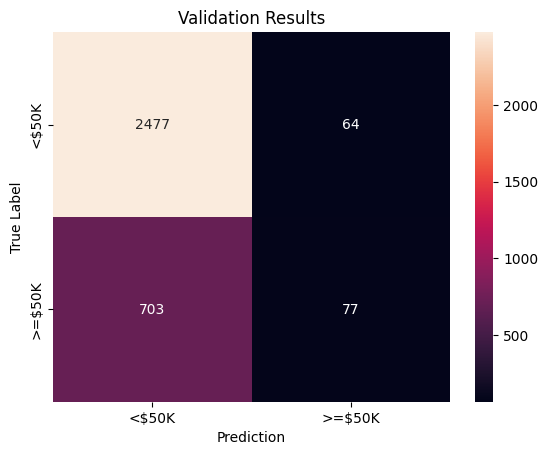

In [ ]:
cm_val = confusion_matrix(y_val.detach().numpy(), outputs_val.detach().numpy().round())
cm_val = pd.DataFrame(cm_val,index=['<$50K','>=$50K'],columns =['<$50K','>=$50K'])
sns.heatmap(cm_val,annot=True,fmt='g') #vmin=0,vmax=1,fmt=".1%"
plt.ylabel("True Label")
plt.xlabel("Prediction")
plt.title("Validation Results")
plt.show()

### Test Confusion Matrix

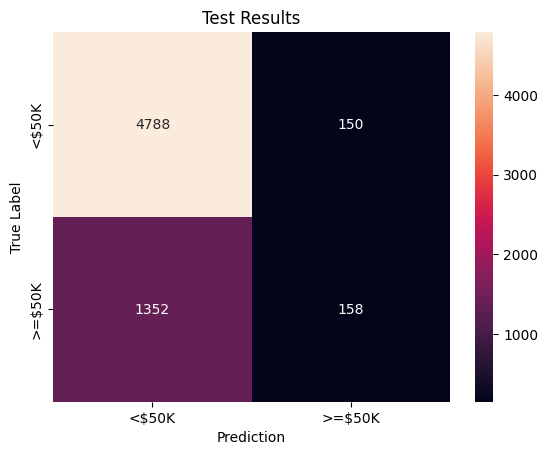

In [ ]:
cm_test = confusion_matrix(y_test.detach().numpy(), outputs_test.detach().numpy().round())
cm_test = pd.DataFrame(cm_test,index=['<$50K','>=$50K'],columns =['<$50K','>=$50K'])
sns.heatmap(cm_test,annot=True,fmt='g') #vmin=0,vmax=1,fmt=".1%"
plt.ylabel("True Label")
plt.xlabel("Prediction")
plt.title("Test Results")
plt.show()

In [ ]:
df.columns

Index(['age', 'juv_fel_count', 'juv_misd_count', 'juv_other_count',
       'priors_count', 'race', 'two_year_recid', 'sex_Female', 'sex_Male',
       'c_charge_degree_F', 'c_charge_degree_M'],
      dtype='object')